# 5. Operating a fleet of aircrafts with multi-agent RL: Independent Q-learning (IQL)

In this notebook, Independent Q-learning is introduced as the most basic multi-agent algorithm to solve the fleet management problem.

#### To install

To install the necessary python libraries, open the Anaconda Prompt, drive to the directory where the `environment.yml` file is and run the following command:

`conda env create -f environment.yml -n rlenv`

This will create a virtual environment with all the required packages (tensorflow, pytorch, gym etc...). Then activate the environment with `conda activate rlenv`.
#### Initial settings

In [1]:
%load_ext autoreload
%autoreload 2

# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime, timedelta
import random
from collections import deque
import time
import copy
import json
import itertools
import shutil
import matplotlib.patches as mpatches
# Pytorch
import torch
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

# setting device on GPU if available, else CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print('Using device:',device)
# print(torch.cuda.get_device_name(0))

# plotting parameters
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# import environment module
import opfleet_env as opfleet

## 2-aircraft environment

Create a 2-aircraft fleet environment with the following parameters:
- 2 mission types (M1 and M5)
- 2 mission prescribed each day, one of each
- lifetime of 5 years (2018-2023)
- reward of +1 for M1 and +2 for M5
- penalty of -10 for preventive maintenance and -100 for corrective maintenance and 5 timesteps of waiting period in both cases
- crack length discretised in 10 levels

In [4]:
run_name = 'example_IQL_2tails'
# create folder to store the outputs 
fp_outputs = os.path.join(os.getcwd(),run_name)
if not os.path.exists(fp_outputs): os.makedirs(fp_outputs)

# store parameters file so it can be loaded for successive runs
if os.path.exists(os.path.join(fp_outputs,'params.pkl')):
    with open(os.path.join(fp_outputs,'params.pkl'),'rb') as f:
        params = pickle.load(f)    
    print('loaded existing params file')
else:
    print('created new params file at %s'%fp_outputs)
    params = {
        
        # Paris law parameters for degradation model
        'b': 76.2/1000,         # body width converted to metres
        'm': 2.9,               # Paris exponent
        'C_median': 8.586e-11+2*0.619e-11,  # median of Paris coefficient C
        'C_std': 3*0.619e-11,     # std of Paris coefficient C 
    
        # initial and critical crack length
         'a0': 9/1000,          # 9mm as in Virkler data converted to metres
         'amax': (76.2/2)/1000, # critical at one third of body width
        
        # assume that cyclic stress frequency is 0.65 Hz (20Hz in Virkler data)
        'f0': 5,
        
        # assume that different maneuvers have different stress range (ds)
        # maneuver m1: ds = 30 MPa (level fly), ds = stress range/amplitude
        # maneuver m2: ds = 50 MPa (take-off & land), ds=48.26 in Virkler data
        # maneuver m3: ds = 70 MPa (barrel rotate)
        # maneuver m4: ds = 90 MPa (pull up/down & turn)
        # maneuver m5: ds = 110 MPa (vertical up/down)
        'maneuvers': [30, 50, 70, 90, 110], # ds for each maneuver
        
        # define 5 types of missions, where different maneuvers are performed
        # Mission  #1: m1(3600sec) - m2(60sec) - m3(40sec) - m4(60sec) - m5(20sec)
        # Mission  #2: m1(4000sec) - m2(60sec) - m3(60sec) - m4(80sec)
        # Mission  #3: m1(3000sec) - m2(60sec) -             m4(70sec) - m5(40sec)
        # Mission  #4: m1(2600sec) - m2(60sec) - m3(30sec) -             m5(10sec)
        # Mission  #5: m1(4500sec) - m2(60sec) -             m4(60sec) - m5(80sec)
        # duration in s:      M1, M2, M3, M4, M5
        'missions': {'M1': [2600, 60, 30, 0 , 10],
                     'M2': [4500, 60, 0 , 60, 80]},    
                                      
        # fleet composition
        'n_tail': 2, 
        
        # episode timeframe (Monday to Friday)
        'date_start': datetime(2018,1,1),   # starting date
        'date_end': datetime(2023,1,1),     # ending date
        
        # prescribed missions, number of daily missions and composition
        'missions_per_day': 2,              # how many missions are prescribed each day
        'mission_composition': 'fixed-constant',  # 3 options for the mission composition:
                                            # 'fixed-constant': fixed number of mission and constant composition (e.g., one of each)
                                            # 'fixed-mixed':    fixed number of missions but random composition  
                                            # 'random':         random number of missions and random composition           
        
        # reward function [-1 per day in maintenance, 0 standby]
        'reward_scheme': 'mission-based', # 3 implemented reward schemes
                                     # 'constant': constant reward [+1 per mission flown]
                                     # 'damage-based': reward based on damage caused
                                     # 'mission-based': reward based on mission type
        # if 'mission-based', specify the rewards
        'reward_per_mission': [1,2], # respective rewards for [M1,M2,M3,M4,M5]

        # maintenance levels      duration repair   cost
        'preventive_maintenance': [5,      30,     10],
        'corrective_maintenance': [5,     30,      100],
        
        # crack length discretation
        'damage_levels': 10,
        }
    
    # generate C coefficients or load if already exists
    if os.path.exists(os.path.join(fp_outputs,'C_values.pkl')):
        with open(os.path.join(fp_outputs,'C_values.pkl'),'rb') as f:
            params['C'] = pickle.load(f)          
        print('C-values were loaded from file')
    else:
        # params['C'] = params['C_median'] + params['C_std']*np.random.normal(size=params['n_tail'])
        params['C'] = np.array([7e-11, 1.3e-10]) # hard-coded to have one slow and one fast degradation path
        with open(os.path.join(fp_outputs,'C_values.pkl'),'wb') as f:
            pickle.dump(params['C'],f)
    
    # save params into a file
    with open(os.path.join(fp_outputs,'params.pkl'),'wb') as f:
        pickle.dump(params,f)
print(params)

loaded existing params file
{'b': 0.0762, 'm': 2.9, 'C_median': 9.824e-11, 'C_std': 1.857e-11, 'a0': 0.009, 'amax': 0.0381, 'f0': 5, 'maneuvers': [30, 50, 70, 90, 110], 'missions': {'M1': [2600, 60, 30, 0, 10], 'M2': [4500, 60, 0, 60, 80]}, 'n_tail': 2, 'date_start': datetime.datetime(2018, 1, 1, 0, 0), 'date_end': datetime.datetime(2023, 1, 1, 0, 0), 'missions_per_day': 2, 'mission_composition': 'fixed-constant', 'reward_scheme': 'mission-based', 'reward_per_mission': [1, 2], 'preventive_maintenance': [5, 30, 10], 'corrective_maintenance': [5, 30, 100], 'damage_levels': 10, 'C': array([7.0e-11, 1.3e-10])}


2610 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 2
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 16
Number of possible states: 81


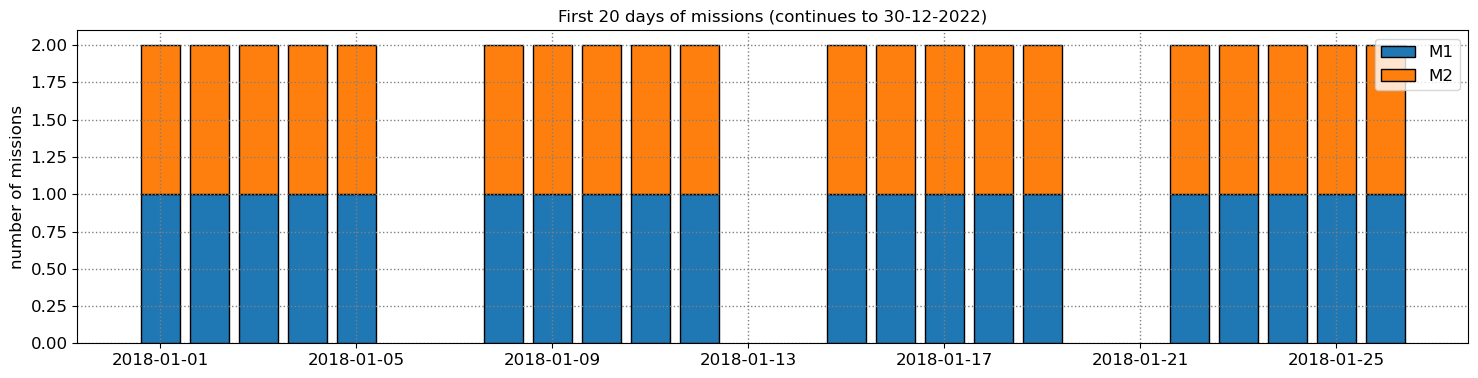

In [5]:
# create the opfleet Env class (contains all the logic to manage the fleet)
env = opfleet.Env(params, verbose=True)

2610 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 2
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 16
Number of possible states: 81


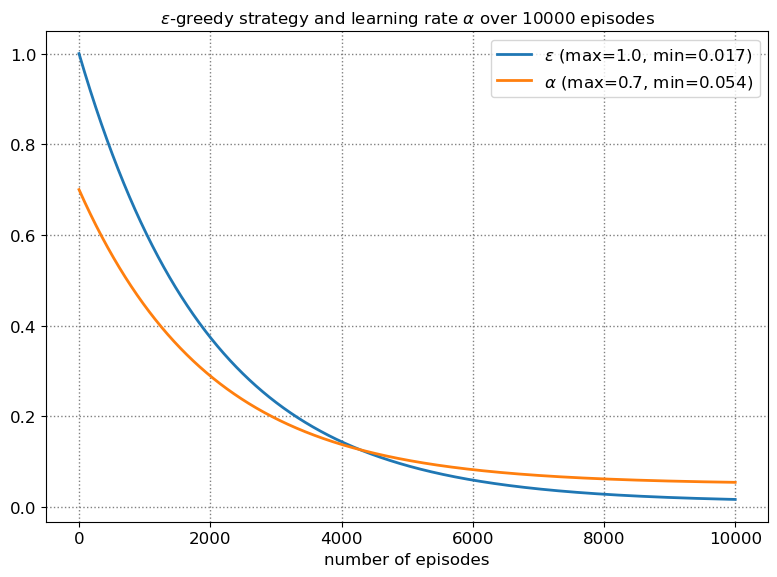

In [7]:
fp = os.path.join(fp_outputs,'IQL_run1')
if not os.path.exists(fp): os.makedirs(fp)

# training parameters
train_params = {
    'n_episodes': 10000,         # number of episodes for the search
    'max_epsilon': 1,         # max epsilon at the start of the search
    'min_epsilon': 0.01,        # minimum exploration rate
    'decay_epsilon': 0.0005,    # epsilon decay
    'max_alpha': 0.7,            # initial alpha value
    'min_alpha': 0.05,          # min alpha
    'decay_alpha': 0.0005,       # alpha decay
    'gamma': 0.9,               # discount factor
    'saving_step': 10,          # how often to save the model
    'n_decisions': 365,         # number of decisions per mini-episode,
    'repetitions': 10,
}

# plot epsilon and alpha decay curves
fig, epsilons, alphas = opfleet.plot_eps_alpha(train_params)
fig.savefig(os.path.join(fp,'epsilon_greedy_search.jpg'))

# store parameters in a text file for reference
with open(os.path.join(fp,'train_params.txt'),'w') as f:
    json.dump(train_params,f,indent=4)
    
# initialise environment
env = opfleet.Env(params,True)
plt.gcf().savefig(os.path.join(fp,'mission_profile.jpg'))
plt.close(plt.gcf())

# draw initial states for each episode from uniform distribution
nei = train_params['n_episodes']
crack_lengths = np.empty((nei,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,nei)
# uncomment for exponential distribution
# random_exp = stats.truncexpon(env.amax*1000,scale=10)
# for k in range(env.n_tail):
#     sampled_cracks = env.amax*1000-random_exp.rvs(nei)
#     sampled_cracks = sampled_cracks[sampled_cracks>=env.a0*1000]
#     crack_lengths[:,k] = np.random.choice(sampled_cracks,nei)
train_params['crack_lengths'] = crack_lengths

In [8]:
# randomly initialise q-table
n_agents = env.n_tail
q_tables = []
states = np.arange(1,10)
for i in range(n_agents):
    q_table = dict([])
    for s in states:     
                state = '%d'%(s)
                q_table[state] = np.random.uniform(-5,5,len(env.action_list))
    q_tables.append(q_table)

10000 - rew 1854 (best 1910) - eps 0.017 - alpha = 0.054

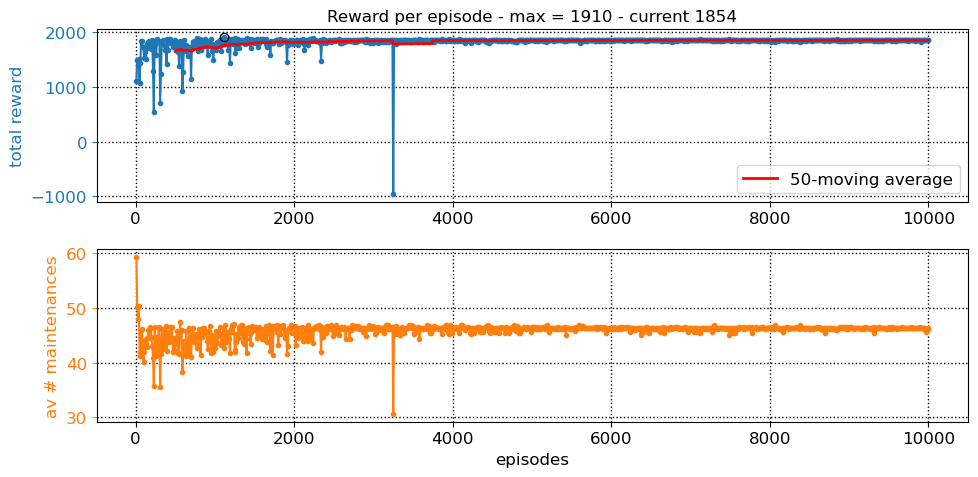

In [11]:
q_tables = opfleet.train_IQL(env,q_tables,train_params,fp)

## 3-aircraft environment

Create a 3-aircraft fleet environment with the following parameters:
- 2 mission types (M1 and M5)
- 3 mission prescribed each day, 1 M1 and 2 M5
- lifetime of 5 years (2018-2023)
- reward of +1 for M1 and +2 for M5
- penalty of -10 for preventive maintenance and -100 for corrective maintenance and 5 timesteps of waiting period in both cases
- crack length discretised in 10 levels

In [12]:
run_name = 'example_IQL_3tails'
# create folder to store the outputs 
fp_outputs = os.path.join(os.getcwd(),run_name)
if not os.path.exists(fp_outputs): os.makedirs(fp_outputs)

# store parameters file so it can be loaded for successive runs
if os.path.exists(os.path.join(fp_outputs,'params.pkl')):
    with open(os.path.join(fp_outputs,'params.pkl'),'rb') as f:
        params = pickle.load(f)    
    print('loaded existing params file')
else:
    print('created new params file at %s'%fp_outputs)
    params = {
        
        # Paris law parameters for degradation model
        'b': 76.2/1000,         # body width converted to metres
        'm': 2.9,               # Paris exponent
        'C_median': 8.586e-11+2*0.619e-11,  # median of Paris coefficient C
        'C_std': 3*0.619e-11,     # std of Paris coefficient C 
    
        # initial and critical crack length
         'a0': 9/1000,          # 9mm as in Virkler data converted to metres
         'amax': (76.2/2)/1000, # critical at one third of body width
        
        # assume that cyclic stress frequency is 0.65 Hz (20Hz in Virkler data)
        'f0': 5,
        
        # assume that different maneuvers have different stress range (ds)
        # maneuver m1: ds = 30 MPa (level fly), ds = stress range/amplitude
        # maneuver m2: ds = 50 MPa (take-off & land), ds=48.26 in Virkler data
        # maneuver m3: ds = 70 MPa (barrel rotate)
        # maneuver m4: ds = 90 MPa (pull up/down & turn)
        # maneuver m5: ds = 110 MPa (vertical up/down)
        'maneuvers': [30, 50, 70, 90, 110], # ds for each maneuver
        
        # define 5 types of missions, where different maneuvers are performed
        # Mission  #1: m1(3600sec) - m2(60sec) - m3(40sec) - m4(60sec) - m5(20sec)
        # Mission  #2: m1(4000sec) - m2(60sec) - m3(60sec) - m4(80sec)
        # Mission  #3: m1(3000sec) - m2(60sec) -             m4(70sec) - m5(40sec)
        # Mission  #4: m1(2600sec) - m2(60sec) - m3(30sec) -             m5(10sec)
        # Mission  #5: m1(4500sec) - m2(60sec) -             m4(60sec) - m5(80sec)
        # duration in s:      M1, M2, M3, M4, M5
        'missions': {'M1': [2600, 60, 30, 0 , 10],
                     'M2': [4500, 60, 0 , 60, 80]},    
                                      
        # fleet composition
        'n_tail': 3,
        
        # episode timeframe (Monday to Friday)
        'date_start': datetime(2018,1,1),   # starting date
        'date_end': datetime(2023,1,1),     # ending date
        
        # prescribed missions, number of daily missions and composition
        'missions_per_day': 3,              # how many missions are prescribed each day
        'mission_composition': 'fixed-constant',  # 3 options for the mission composition:
                                            # 'fixed-constant': fixed number of mission and constant composition (e.g., one of each)
                                            # 'fixed-mixed':    fixed number of missions but random composition  
                                            # 'random':         random number of missions and random composition           
        
        # reward function [-1 per day in maintenance, 0 standby]
        'reward_scheme': 'mission-based', # 3 implemented reward schemes
                                     # 'constant': constant reward [+1 per mission flown]
                                     # 'damage-based': reward based on damage caused
                                     # 'mission-based': reward based on mission type
        # if 'mission-based', specify the rewards
        'reward_per_mission': [1,2], # respective rewards for [M1,M2,M3,M4,M5]

        # maintenance levels      duration repair   cost
        'preventive_maintenance': [5,      30,     10],
        'corrective_maintenance': [5,     30,      100],
        
        # crack length discretation
        'damage_levels': 10,
        }
    
    # generate C coefficients or load if already exists
    if os.path.exists(os.path.join(fp_outputs,'C_values.pkl')):
        with open(os.path.join(fp_outputs,'C_values.pkl'),'rb') as f:
            params['C'] = pickle.load(f)          
        print('C-values were loaded from file')
    else:
        # params['C'] = params['C_median'] + params['C_std']*np.random.normal(size=params['n_tail'])
        params['C'] = np.array([7e-11, 9e-11, 1.3e-10])
        with open(os.path.join(fp_outputs,'C_values.pkl'),'wb') as f:
            pickle.dump(params['C'],f)
    
    # save params into a file
    with open(os.path.join(fp_outputs,'params.pkl'),'wb') as f:
        pickle.dump(params,f)
print(params)

created new params file at C:\Users\z5030440\OneDrive - UNSW\Documents\RLfleet\example_IQL_3tails
{'b': 0.0762, 'm': 2.9, 'C_median': 9.824e-11, 'C_std': 1.857e-11, 'a0': 0.009, 'amax': 0.0381, 'f0': 5, 'maneuvers': [30, 50, 70, 90, 110], 'missions': {'M1': [2600, 60, 30, 0, 10], 'M2': [4500, 60, 0, 60, 80]}, 'n_tail': 3, 'date_start': datetime.datetime(2018, 1, 1, 0, 0), 'date_end': datetime.datetime(2023, 1, 1, 0, 0), 'missions_per_day': 3, 'mission_composition': 'fixed-constant', 'reward_scheme': 'mission-based', 'reward_per_mission': [1, 2], 'preventive_maintenance': [5, 30, 10], 'corrective_maintenance': [5, 30, 100], 'damage_levels': 10, 'C': array([7.0e-11, 9.0e-11, 1.3e-10])}


3915 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 3
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 64
Number of possible states: 729


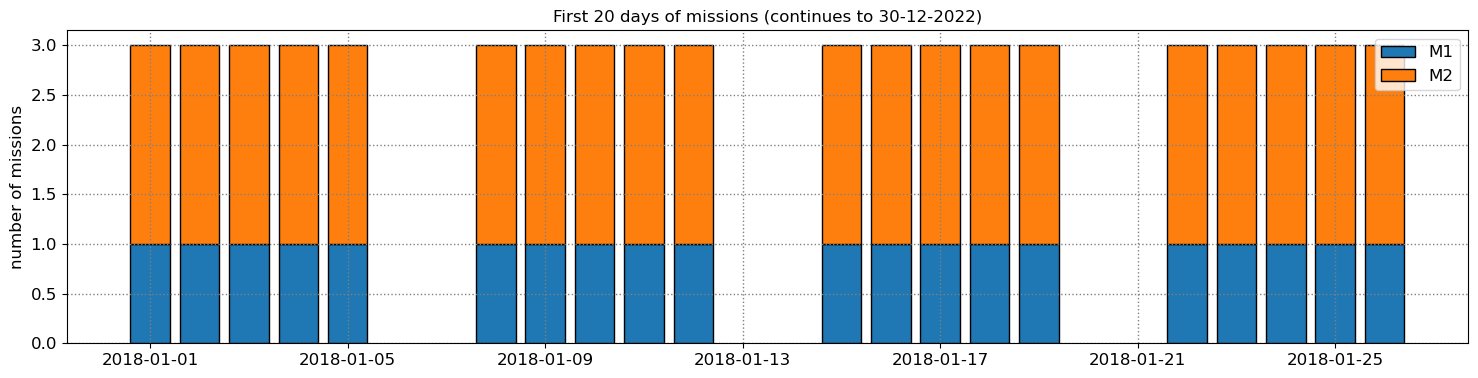

In [13]:
# create the opfleet Env class (contains all the logic to manage the fleet)
env = opfleet.Env(params, verbose=True)

3915 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 3
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 64
Number of possible states: 729


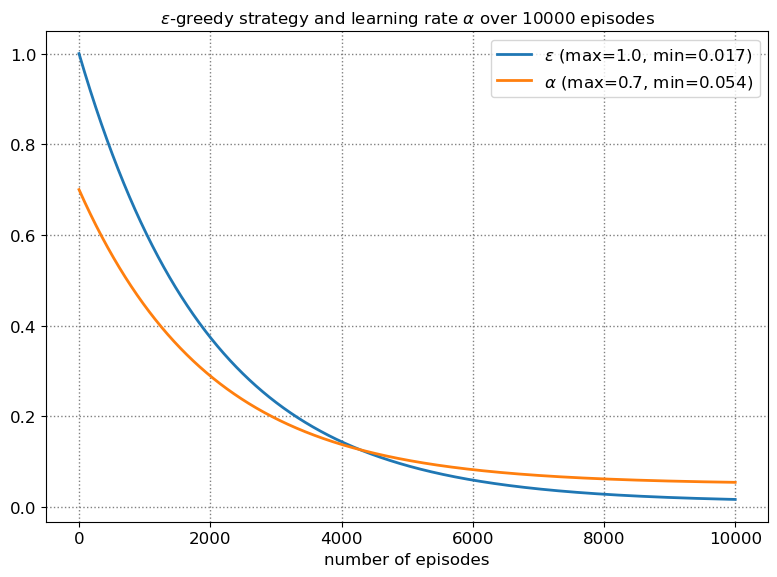

In [14]:
fp = os.path.join(fp_outputs,'IQL_run1')
if not os.path.exists(fp): os.makedirs(fp)

# training parameters
train_params = {
    'n_episodes': 10000,         # number of episodes for the search
    'max_epsilon': 1,         # max epsilon at the start of the search
    'min_epsilon': 0.01,        # minimum exploration rate
    'decay_epsilon': 0.0005,    # epsilon decay
    'max_alpha': 0.7,            # initial alpha value
    'min_alpha': 0.05,          # min alpha
    'decay_alpha': 0.0005,       # alpha decay
    'gamma': 0.9,               # discount factor
    'saving_step': 10,          # how often to save the model
    'n_decisions': 365,         # number of decisions per mini-episode,
    'repetitions': 10,
}

# plot epsilon and alpha decay curves
fig, epsilons, alphas = opfleet.plot_eps_alpha(train_params)
fig.savefig(os.path.join(fp,'epsilon_greedy_search.jpg'))

# store parameters in a text file for reference
with open(os.path.join(fp,'train_params.txt'),'w') as f:
    json.dump(train_params,f,indent=4)
    
# initialise environment
env = opfleet.Env(params,True)
plt.gcf().savefig(os.path.join(fp,'mission_profile.jpg'))
plt.close(plt.gcf())

# draw initial states for each episode from uniform distribution
nei = train_params['n_episodes']
crack_lengths = np.empty((nei,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,nei)
# uncomment for exponential distribution
# random_exp = stats.truncexpon(env.amax*1000,scale=10)
# for k in range(env.n_tail):
#     sampled_cracks = env.amax*1000-random_exp.rvs(nei)
#     sampled_cracks = sampled_cracks[sampled_cracks>=env.a0*1000]
#     crack_lengths[:,k] = np.random.choice(sampled_cracks,nei)
train_params['crack_lengths'] = crack_lengths

In [15]:
# randomly initialise q-table
n_agents = env.n_tail
q_tables = []
states = np.arange(1,10)
for i in range(n_agents):
    q_table = dict([])
    for s in states:     
                state = '%d'%(s)
                q_table[state] = np.random.uniform(-5,5,len(env.action_list))
    q_tables.append(q_table)

10000 - rew 3006 (best 3033) - eps 0.017 - alpha = 0.054

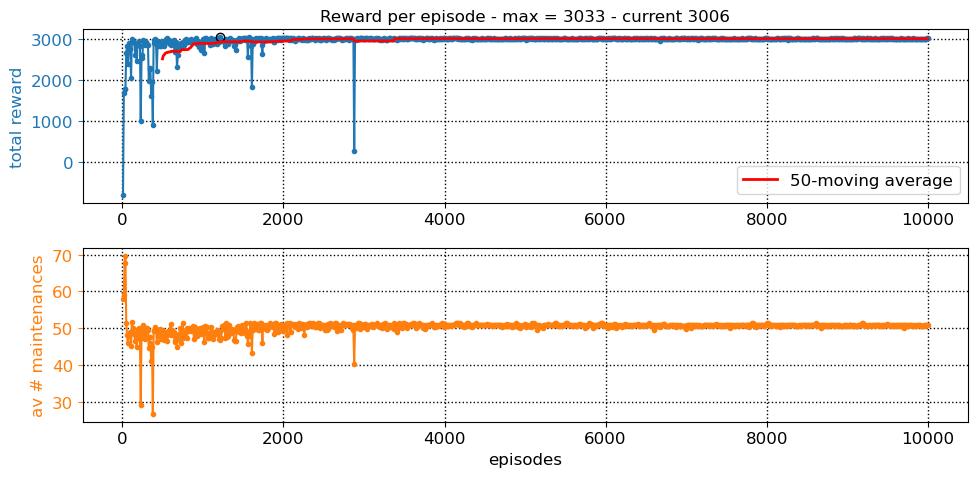

In [16]:
q_tables = opfleet.train_IQL(env,q_tables,train_params,fp)

## 4-aircraft environment

Create a 4-aircraft fleet environment with the following parameters:
- 2 mission types (M1 and M5)
- 4 mission prescribed each day, 2 M1 and 2 M5
- lifetime of 5 years (2018-2023)
- reward of +1 for M1 and +2 for M5
- penalty of -10 for preventive maintenance and -100 for corrective maintenance and 5 timesteps of waiting period in both cases
- crack length discretised in 10 levels

In [17]:
run_name = 'example_IQL_4tails'
# create folder to store the outputs 
fp_outputs = os.path.join(os.getcwd(),run_name)
if not os.path.exists(fp_outputs): os.makedirs(fp_outputs)

# store parameters file so it can be loaded for successive runs
if os.path.exists(os.path.join(fp_outputs,'params.pkl')):
    with open(os.path.join(fp_outputs,'params.pkl'),'rb') as f:
        params = pickle.load(f)    
    print('loaded existing params file')
else:
    print('created new params file at %s'%fp_outputs)
    params = {
        
        # Paris law parameters for degradation model
        'b': 76.2/1000,         # body width converted to metres
        'm': 2.9,               # Paris exponent
        'C_median': 8.586e-11+2*0.619e-11,  # median of Paris coefficient C
        'C_std': 3*0.619e-11,     # std of Paris coefficient C 
    
        # initial and critical crack length
         'a0': 9/1000,          # 9mm as in Virkler data converted to metres
         'amax': (76.2/2)/1000, # critical at one third of body width
        
        # assume that cyclic stress frequency is 0.65 Hz (20Hz in Virkler data)
        'f0': 5,
        
        # assume that different maneuvers have different stress range (ds)
        # maneuver m1: ds = 30 MPa (level fly), ds = stress range/amplitude
        # maneuver m2: ds = 50 MPa (take-off & land), ds=48.26 in Virkler data
        # maneuver m3: ds = 70 MPa (barrel rotate)
        # maneuver m4: ds = 90 MPa (pull up/down & turn)
        # maneuver m5: ds = 110 MPa (vertical up/down)
        'maneuvers': [30, 50, 70, 90, 110], # ds for each maneuver
        
        # define 5 types of missions, where different maneuvers are performed
        # Mission  #1: m1(3600sec) - m2(60sec) - m3(40sec) - m4(60sec) - m5(20sec)
        # Mission  #2: m1(4000sec) - m2(60sec) - m3(60sec) - m4(80sec)
        # Mission  #3: m1(3000sec) - m2(60sec) -             m4(70sec) - m5(40sec)
        # Mission  #4: m1(2600sec) - m2(60sec) - m3(30sec) -             m5(10sec)
        # Mission  #5: m1(4500sec) - m2(60sec) -             m4(60sec) - m5(80sec)
        # duration in s:      M1, M2, M3, M4, M5
        'missions': {'M1': [2600, 60, 30, 0 , 10],
                     'M2': [4500, 60, 0 , 60, 80]},    
                                      
        # fleet composition
        'n_tail': 4, 

        # episode timeframe (Monday to Friday)
        'date_start': datetime(2018,1,1),   # starting date
        'date_end': datetime(2023,1,1),     # ending date
        
        # prescribed missions, number of daily missions and composition
        'missions_per_day': 4,              # how many missions are prescribed each day
        'mission_composition': 'fixed-constant',  # 3 options for the mission composition:
                                            # 'fixed-constant': fixed number of mission and constant composition (e.g., one of each)
                                            # 'fixed-mixed':    fixed number of missions but random composition  
                                            # 'random':         random number of missions and random composition           
        
        # reward function [-1 per day in maintenance, 0 standby]
        'reward_scheme': 'mission-based', # 3 implemented reward schemes
                                     # 'constant': constant reward [+1 per mission flown]
                                     # 'damage-based': reward based on damage caused
                                     # 'mission-based': reward based on mission type
        # if 'mission-based', specify the rewards
        'reward_per_mission': [1,2], # respective rewards for [M1,M2,M3,M4,M5]

        # maintenance levels      duration repair   cost
        'preventive_maintenance': [5,      30,     10],
        'corrective_maintenance': [5,     30,      100],
        
        # crack length discretation
        'damage_levels': 10,
        }
    
    # generate C coefficients or load if already exists
    if os.path.exists(os.path.join(fp_outputs,'C_values.pkl')):
        with open(os.path.join(fp_outputs,'C_values.pkl'),'rb') as f:
            params['C'] = pickle.load(f)          
        print('C-values were loaded from file')
    else:
        # params['C'] = params['C_median'] + params['C_std']*np.random.normal(size=params['n_tail'])
        params['C'] = np.array([7e-11, 9e-11, 1.1e-10, 1.3e-10])
        with open(os.path.join(fp_outputs,'C_values.pkl'),'wb') as f:
            pickle.dump(params['C'],f)
    
    # save params into a file
    with open(os.path.join(fp_outputs,'params.pkl'),'wb') as f:
        pickle.dump(params,f)
print(params)

created new params file at C:\Users\z5030440\OneDrive - UNSW\Documents\RLfleet\example_IQL_4tails
{'b': 0.0762, 'm': 2.9, 'C_median': 9.824e-11, 'C_std': 1.857e-11, 'a0': 0.009, 'amax': 0.0381, 'f0': 5, 'maneuvers': [30, 50, 70, 90, 110], 'missions': {'M1': [2600, 60, 30, 0, 10], 'M2': [4500, 60, 0, 60, 80]}, 'n_tail': 4, 'date_start': datetime.datetime(2018, 1, 1, 0, 0), 'date_end': datetime.datetime(2023, 1, 1, 0, 0), 'missions_per_day': 4, 'mission_composition': 'fixed-constant', 'reward_scheme': 'mission-based', 'reward_per_mission': [1, 2], 'preventive_maintenance': [5, 30, 10], 'corrective_maintenance': [5, 30, 100], 'damage_levels': 10, 'C': array([7.0e-11, 9.0e-11, 1.1e-10, 1.3e-10])}


5220 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 4
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 256
Number of possible states: 6561


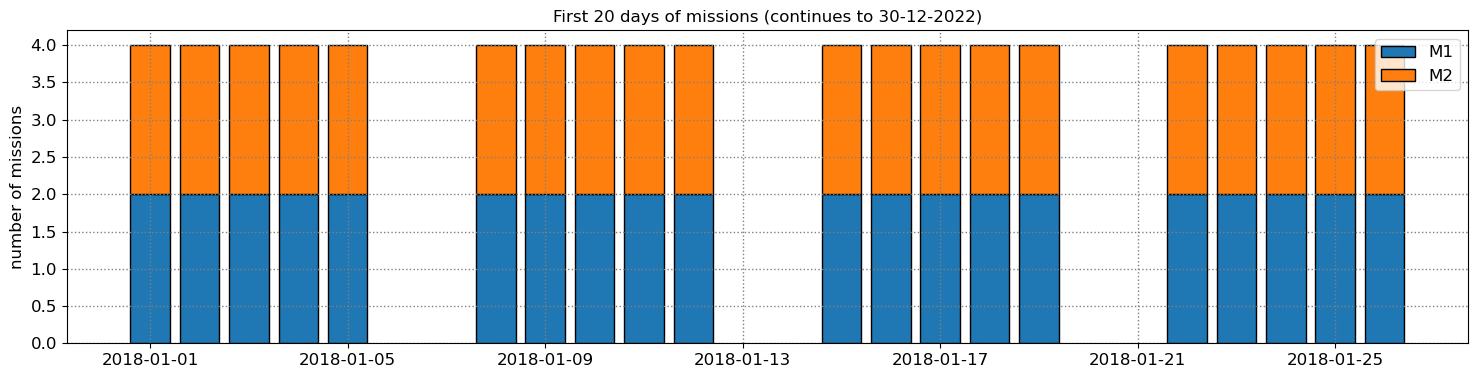

In [18]:
# create the opfleet Env class (contains all the logic to manage the fleet)
env = opfleet.Env(params, verbose=True)

5220 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 4
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 256
Number of possible states: 6561


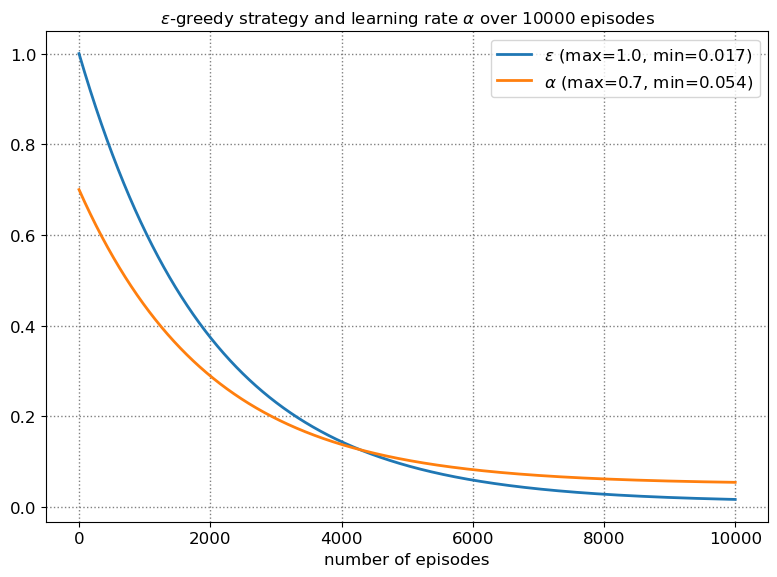

In [19]:
fp = os.path.join(fp_outputs,'IQL_run1')
if not os.path.exists(fp): os.makedirs(fp)

# training parameters
train_params = {
    'n_episodes': 10000,         # number of episodes for the search
    'max_epsilon': 1,         # max epsilon at the start of the search
    'min_epsilon': 0.01,        # minimum exploration rate
    'decay_epsilon': 0.0005,    # epsilon decay
    'max_alpha': 0.7,            # initial alpha value
    'min_alpha': 0.05,          # min alpha
    'decay_alpha': 0.0005,       # alpha decay
    'gamma': 0.9,               # discount factor
    'saving_step': 10,          # how often to save the model
    'n_decisions': 365,         # number of decisions per mini-episode,
    'repetitions': 10,
}

# plot epsilon and alpha decay curves
fig, epsilons, alphas = opfleet.plot_eps_alpha(train_params)
fig.savefig(os.path.join(fp,'epsilon_greedy_search.jpg'))

# store parameters in a text file for reference
with open(os.path.join(fp,'train_params.txt'),'w') as f:
    json.dump(train_params,f,indent=4)
    
# initialise environment
env = opfleet.Env(params,True)
plt.gcf().savefig(os.path.join(fp,'mission_profile.jpg'))
plt.close(plt.gcf())

# draw initial states for each episode from uniform distribution
nei = train_params['n_episodes']
crack_lengths = np.empty((nei,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,nei)
# uncomment for exponential distribution
# random_exp = stats.truncexpon(env.amax*1000,scale=10)
# for k in range(env.n_tail):
#     sampled_cracks = env.amax*1000-random_exp.rvs(nei)
#     sampled_cracks = sampled_cracks[sampled_cracks>=env.a0*1000]
#     crack_lengths[:,k] = np.random.choice(sampled_cracks,nei)
train_params['crack_lengths'] = crack_lengths

In [20]:
# randomly initialise q-table
n_agents = env.n_tail
q_tables = []
states = np.arange(1,10)
for i in range(n_agents):
    q_table = dict([])
    for s in states:     
                state = '%d'%(s)
                q_table[state] = np.random.uniform(-5,5,len(env.action_list))
    q_tables.append(q_table)

10000 - rew 3697 (best 3746) - eps 0.017 - alpha = 0.054

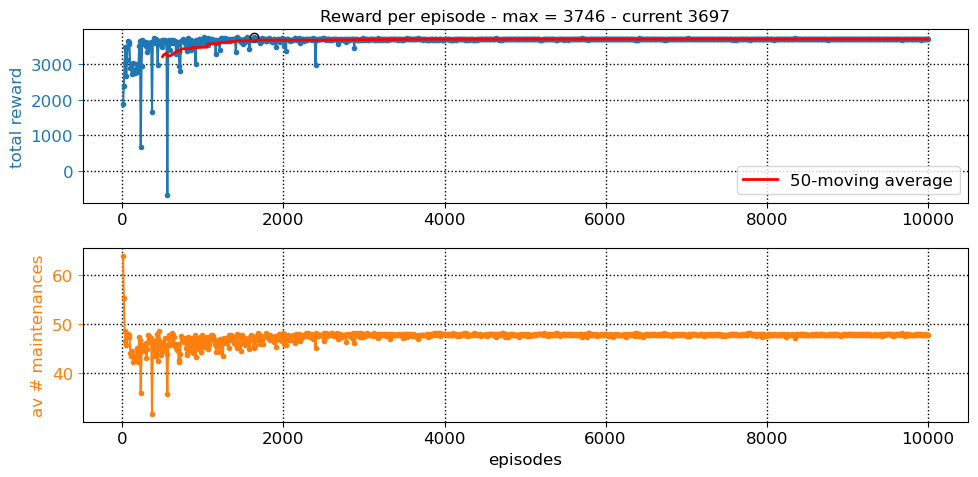

In [21]:
q_tables = opfleet.train_IQL(env,q_tables,train_params,fp)

## Comparison against baselines

Compare the IQL policies against the baselines for each environment tested.

 running maintenance at level 9/10
Optimum maintenance level for on-condition policy: damage level of 8
Optimum maintenance level for force-life policy: damage level of 8
Optimum maintenance level for equal-stress policy: damage level of 8
 running maintenance at level 9/10
Optimum maintenance level for on-condition policy: damage level of 8
Optimum maintenance level for force-life policy: damage level of 7
Optimum maintenance level for equal-stress policy: damage level of 8
 running maintenance at level 9/10
Optimum maintenance level for on-condition policy: damage level of 8
Optimum maintenance level for force-life policy: damage level of 7
Optimum maintenance level for equal-stress policy: damage level of 8
 running episode 1000/1000

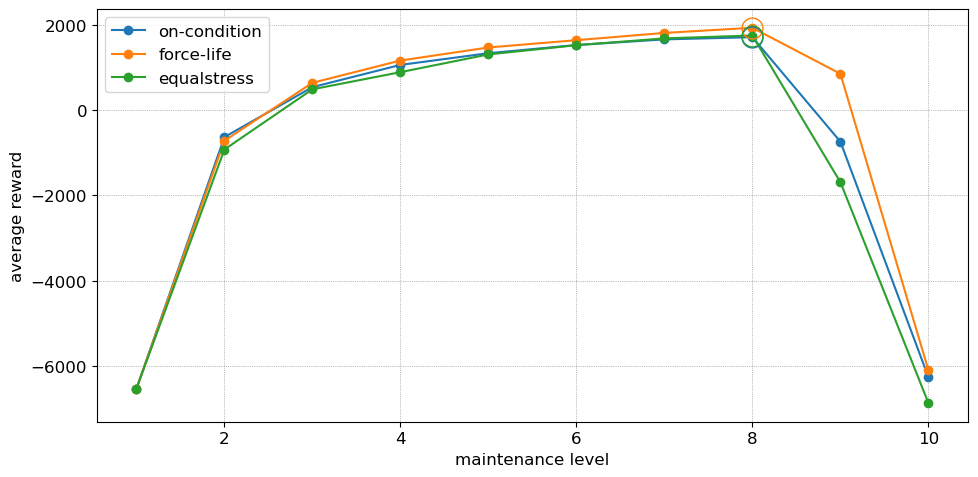

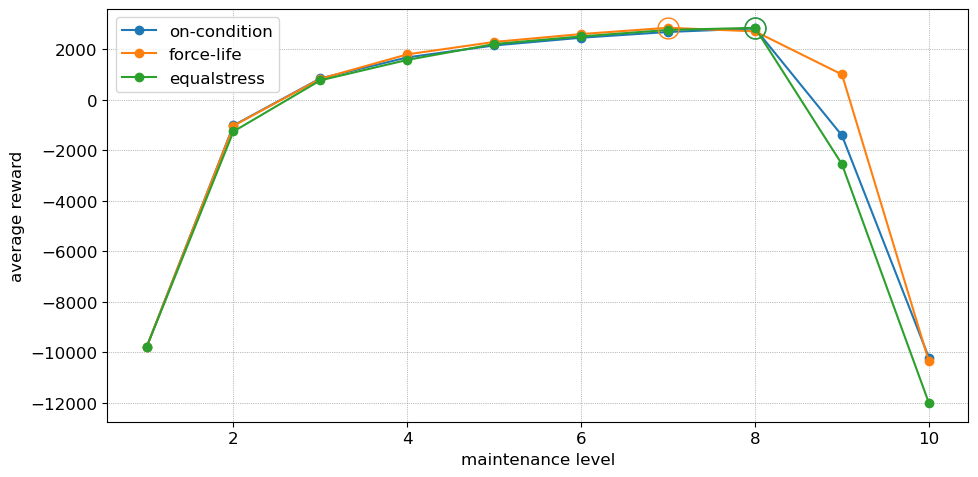

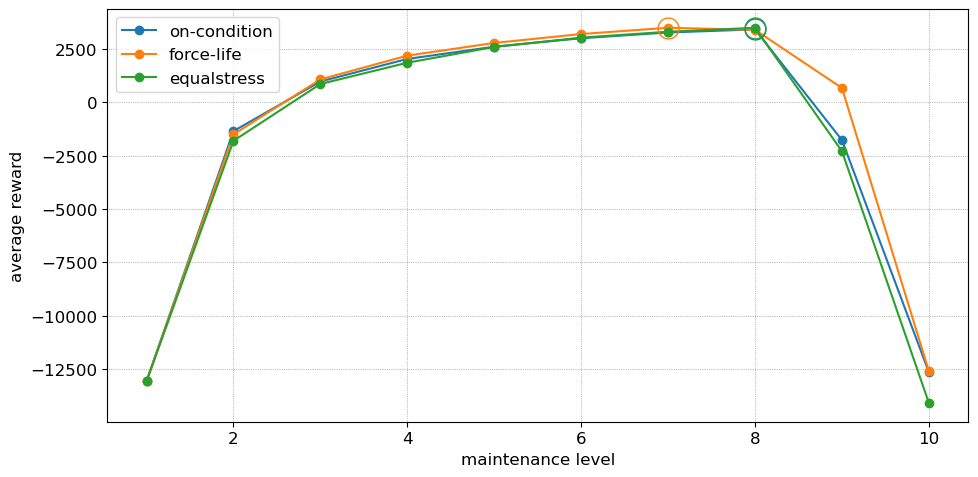

In [26]:
N = 1000
for n_aircrafts in [2,3,4]:
    run_name = 'example_IQL_%dtails'%n_aircrafts
    # load env
    fp_outputs = os.path.join(os.getcwd(),run_name)
    with open(os.path.join(fp_outputs,'params.pkl'),'rb') as f:
        params = pickle.load(f) 
    env = opfleet.Env(params)
    # load qtable
    fp = os.path.join(fp_outputs,'IQL_run1')
    with open(os.path.join(fp,'qtable_best.pkl'),'rb') as f:
        q_tables = pickle.load(f)
    # find optimal maintenance threshold for each policy
    level_oncond, level_forcelife, level_equalstress, fig  = opfleet.optimise_baselines(env,repetitions=10)
    # run N episodes with each policy
    maint_levels = {'level_oncond':level_oncond,'level_forcelife':level_forcelife,'level_equalstress':level_equalstress}
    rewards_baselines = opfleet.run_episodes_baselines(env,maint_levels,N)
    # run N episodes with qtable
    rewards_qtable = opfleet.run_episodes_qtable_multiagent(env,q_tables,N)
    # store in files
    fp_baselines = os.path.join(fp_outputs,'reward_baselines.pkl')
    with open(fp_baselines,'wb') as f:
        pickle.dump(rewards_baselines,f)
    fp_RL = os.path.join(fp_outputs,'reward_RL_Qtable.pkl')
    with open(fp_RL,'wb') as f:
        pickle.dump(rewards_qtable,f)

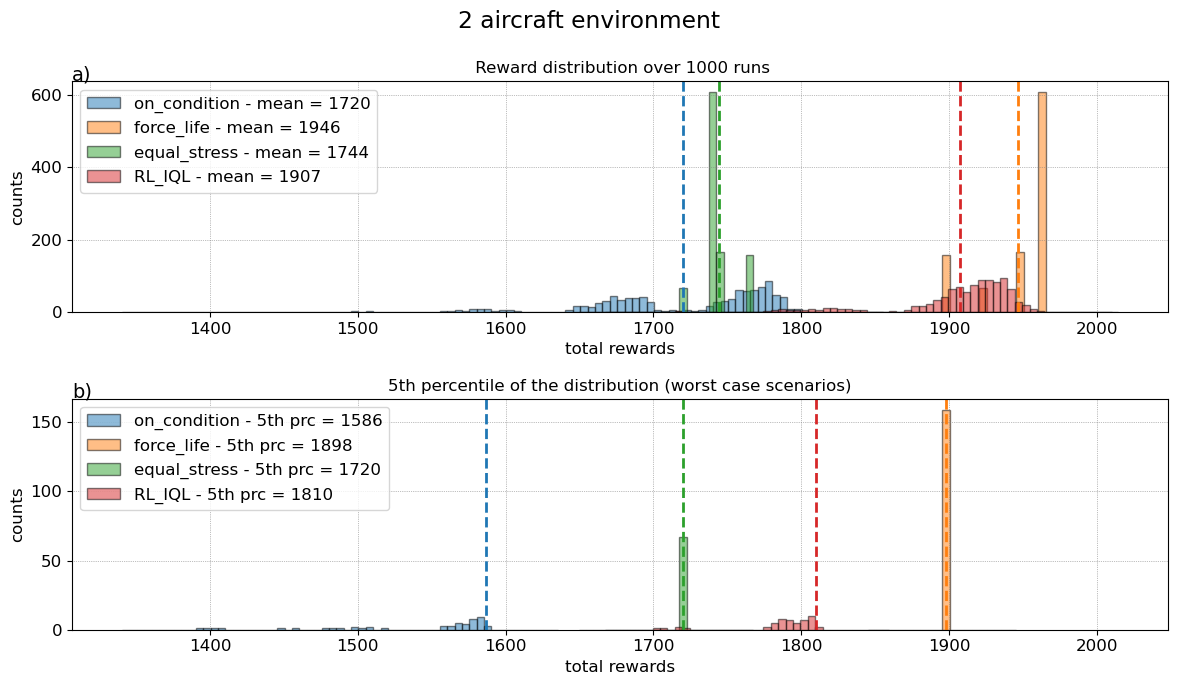

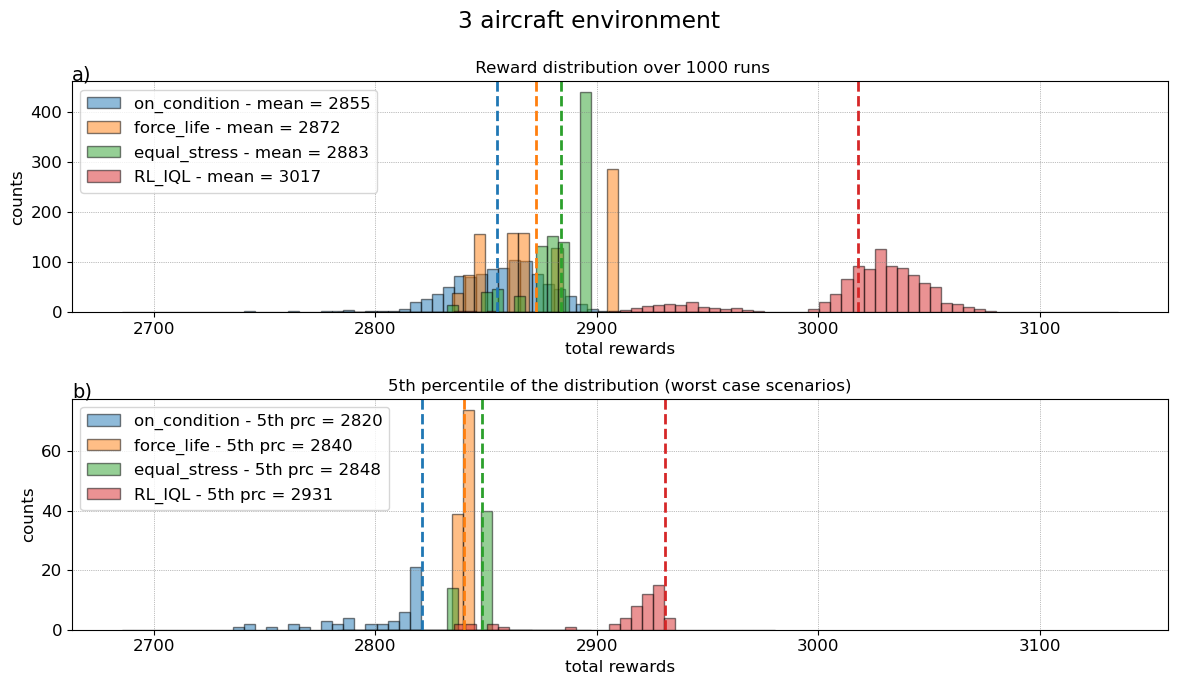

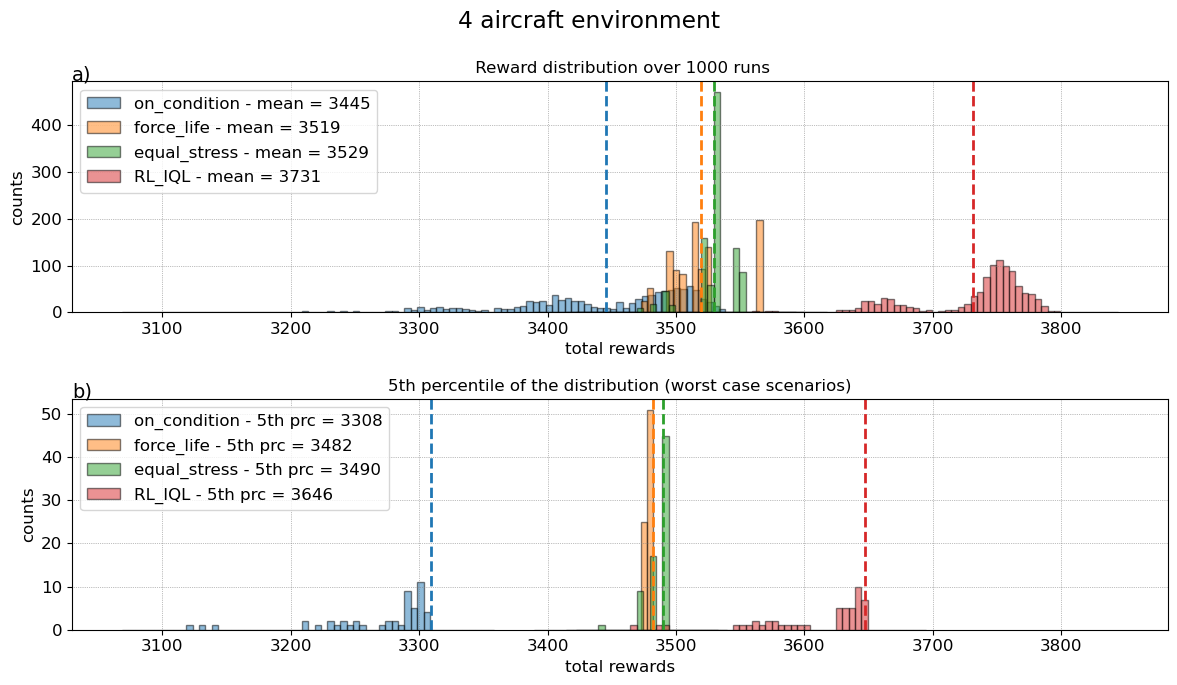

In [31]:
# plot comparisons
for n_aircrafts in [2,3,4]:
    run_name = 'example_IQL_%dtails'%n_aircrafts
    fp_outputs = os.path.join(os.getcwd(),run_name)
    fp_baselines = os.path.join(fp_outputs,'reward_baselines.pkl')
    with open(fp_baselines,'rb') as f:
        rewards_baselines = pickle.load(f)
    fp_RL = os.path.join(fp_outputs,'reward_RL_Qtable.pkl')
    with open(fp_RL,'rb') as f:
        rewards_qtable = pickle.load(f)
    rewards_baselines['RL_IQL'] = rewards_qtable
    # plot reward distributions
    fig = opfleet.plot_reward_distributions(rewards_baselines, binwidth=5)
    fig.suptitle('%d aircraft environment'%n_aircrafts)
    fig.savefig(os.path.join(fp_outputs,'policy_evaluation.jpg'))

## Concluding remarks

In this notebook we showed the performance of multi-agent RL in the form of Independent Q-learning (IQL) against the baseline strategies for the 2, 3 and 4 aircraft environments.
The results indicate the IQL can outperform the baselines and does so with a very fast computational time compared to standard Q-learning (where 1 million episodes were necessary for the 4-aircraft environment).
Future work should focus on integrating a cooperative behaviour in the IQL framework, the first attempt should be Value Decomposition Networks (VDN).


## 6-aircraft environment

Create a 4-aircraft fleet environment with the following parameters:
- 2 mission types (M1 and M5)
- 6 mission prescribed each day, 3 M1 and 3 M5
- lifetime of 5 years (2018-2023)
- reward of +1 for M1 and +2 for M5
- penalty of -10 for preventive maintenance and -100 for corrective maintenance and 5 timesteps of waiting period in both cases
- crack length discretised in 10 levels

In [37]:
run_name = 'example_IQL_6tails'
# create folder to store the outputs 
fp_outputs = os.path.join(os.getcwd(),run_name)
if not os.path.exists(fp_outputs): os.makedirs(fp_outputs)

# store parameters file so it can be loaded for successive runs
if os.path.exists(os.path.join(fp_outputs,'params.pkl')):
    with open(os.path.join(fp_outputs,'params.pkl'),'rb') as f:
        params = pickle.load(f)    
    print('loaded existing params file')
else:
    print('created new params file at %s'%fp_outputs)
    params = {
        
        # Paris law parameters for degradation model
        'b': 76.2/1000,         # body width converted to metres
        'm': 2.9,               # Paris exponent
        'C_median': 8.586e-11+2*0.619e-11,  # median of Paris coefficient C
        'C_std': 3*0.619e-11,     # std of Paris coefficient C 
    
        # initial and critical crack length
         'a0': 9/1000,          # 9mm as in Virkler data converted to metres
         'amax': (76.2/2)/1000, # critical at one third of body width
        
        # assume that cyclic stress frequency is 0.65 Hz (20Hz in Virkler data)
        'f0': 5,
        
        # assume that different maneuvers have different stress range (ds)
        # maneuver m1: ds = 30 MPa (level fly), ds = stress range/amplitude
        # maneuver m2: ds = 50 MPa (take-off & land), ds=48.26 in Virkler data
        # maneuver m3: ds = 70 MPa (barrel rotate)
        # maneuver m4: ds = 90 MPa (pull up/down & turn)
        # maneuver m5: ds = 110 MPa (vertical up/down)
        'maneuvers': [30, 50, 70, 90, 110], # ds for each maneuver
        
        # define 5 types of missions, where different maneuvers are performed
        # Mission  #1: m1(3600sec) - m2(60sec) - m3(40sec) - m4(60sec) - m5(20sec)
        # Mission  #2: m1(4000sec) - m2(60sec) - m3(60sec) - m4(80sec)
        # Mission  #3: m1(3000sec) - m2(60sec) -             m4(70sec) - m5(40sec)
        # Mission  #4: m1(2600sec) - m2(60sec) - m3(30sec) -             m5(10sec)
        # Mission  #5: m1(4500sec) - m2(60sec) -             m4(60sec) - m5(80sec)
        # duration in s:      M1, M2, M3, M4, M5
        'missions': {'M1': [2600, 60, 30, 0 , 10],
                     'M2': [4500, 60, 0 , 60, 80]},    
                                      
        # fleet composition
        'n_tail': 6, 

        # episode timeframe (Monday to Friday)
        'date_start': datetime(2018,1,1),   # starting date
        'date_end': datetime(2023,1,1),     # ending date
        
        # prescribed missions, number of daily missions and composition
        'missions_per_day': 6,              # how many missions are prescribed each day
        'mission_composition': 'fixed-constant',  # 3 options for the mission composition:
                                            # 'fixed-constant': fixed number of mission and constant composition (e.g., one of each)
                                            # 'fixed-mixed':    fixed number of missions but random composition  
                                            # 'random':         random number of missions and random composition           
        
        # reward function [-1 per day in maintenance, 0 standby]
        'reward_scheme': 'mission-based', # 3 implemented reward schemes
                                     # 'constant': constant reward [+1 per mission flown]
                                     # 'damage-based': reward based on damage caused
                                     # 'mission-based': reward based on mission type
        # if 'mission-based', specify the rewards
        'reward_per_mission': [1,2], # respective rewards for [M1,M2,M3,M4,M5]

        # maintenance levels      duration repair   cost
        'preventive_maintenance': [5,      30,     10],
        'corrective_maintenance': [5,     30,      100],
        
        # crack length discretation
        'damage_levels': 10,
        }
    
    # generate C coefficients or load if already exists
    if os.path.exists(os.path.join(fp_outputs,'C_values.pkl')):
        with open(os.path.join(fp_outputs,'C_values.pkl'),'rb') as f:
            params['C'] = pickle.load(f)          
        print('C-values were loaded from file')
    else:
        # params['C'] = params['C_median'] + params['C_std']*np.random.normal(size=params['n_tail'])
        params['C'] = np.array([7e-11, 9e-11, 1.1e-10, 1.3e-10, 1.5e-10, 1.7e-10])
        with open(os.path.join(fp_outputs,'C_values.pkl'),'wb') as f:
            pickle.dump(params['C'],f)
    
    # save params into a file
    with open(os.path.join(fp_outputs,'params.pkl'),'wb') as f:
        pickle.dump(params,f)
print(params)

created new params file at C:\Users\z5030440\OneDrive - UNSW\Documents\RLfleet\example_IQL_6tails
{'b': 0.0762, 'm': 2.9, 'C_median': 9.824e-11, 'C_std': 1.857e-11, 'a0': 0.009, 'amax': 0.0381, 'f0': 5, 'maneuvers': [30, 50, 70, 90, 110], 'missions': {'M1': [2600, 60, 30, 0, 10], 'M2': [4500, 60, 0, 60, 80]}, 'n_tail': 6, 'date_start': datetime.datetime(2018, 1, 1, 0, 0), 'date_end': datetime.datetime(2023, 1, 1, 0, 0), 'missions_per_day': 6, 'mission_composition': 'fixed-constant', 'reward_scheme': 'mission-based', 'reward_per_mission': [1, 2], 'preventive_maintenance': [5, 30, 10], 'corrective_maintenance': [5, 30, 100], 'damage_levels': 10, 'C': array([7.0e-11, 9.0e-11, 1.1e-10, 1.3e-10, 1.5e-10, 1.7e-10])}


7830 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 6
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 4096
Number of possible states: 531441


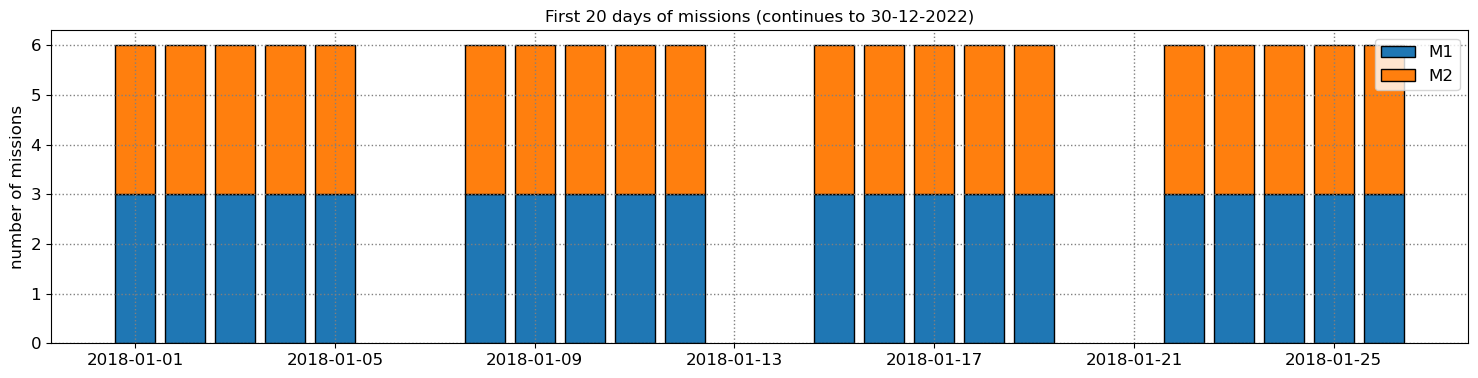

In [38]:
# create the opfleet Env class (contains all the logic to manage the fleet)
env = opfleet.Env(params, verbose=True)

using provided C values


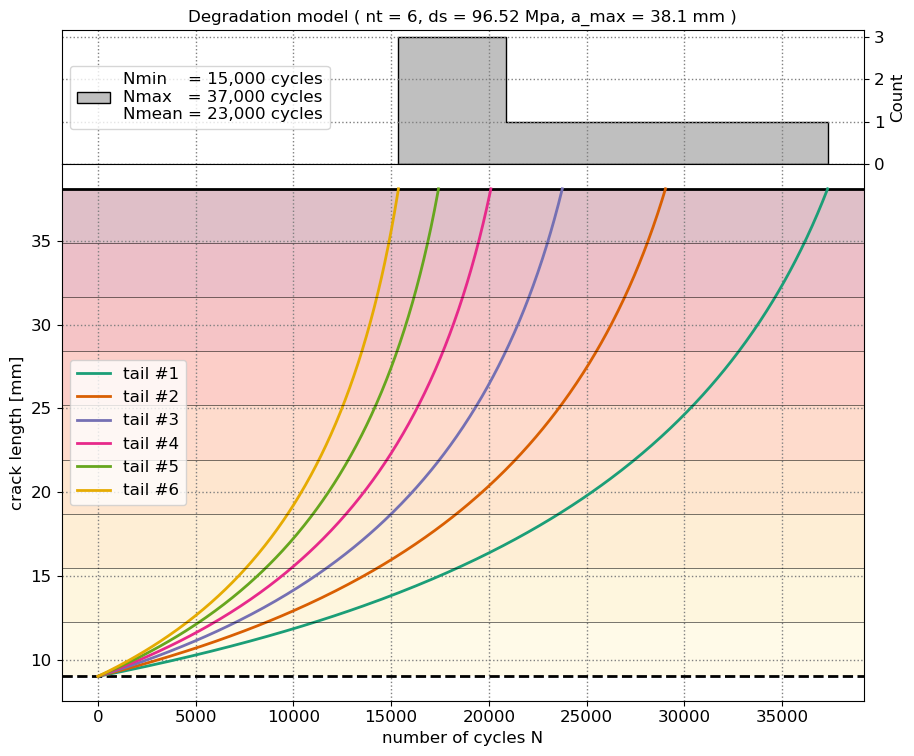

In [39]:
ds = 48.26*2                # stress range in MPa, depends on manoeuvre
nt = 68*3                   # number of trajectories
a_max = 76.2/2              # maximum crack length allowable in mm
N, N_min, a, C, fig = opfleet.degradation_model(ds,nt,a_max,2,C=params['C'],
                                                levels=params['damage_levels'])

7830 missions generated from 01-01-2018 to 30-12-2022 (1305 days)
Number of aircrafts: 6
Number of actions per tail number: 4
['M1', 'M2', 'SB', 'MT']
Mission mode: fixed-constant
Reward scheme: mission-based
Cyclic stress frequency: 5 Hz
Preventive maintenance: 5 days 30 mm 10$
Corrective maintenance: 5 days 30 mm 100$
Number of possible actions: 4096
Number of possible states: 531441


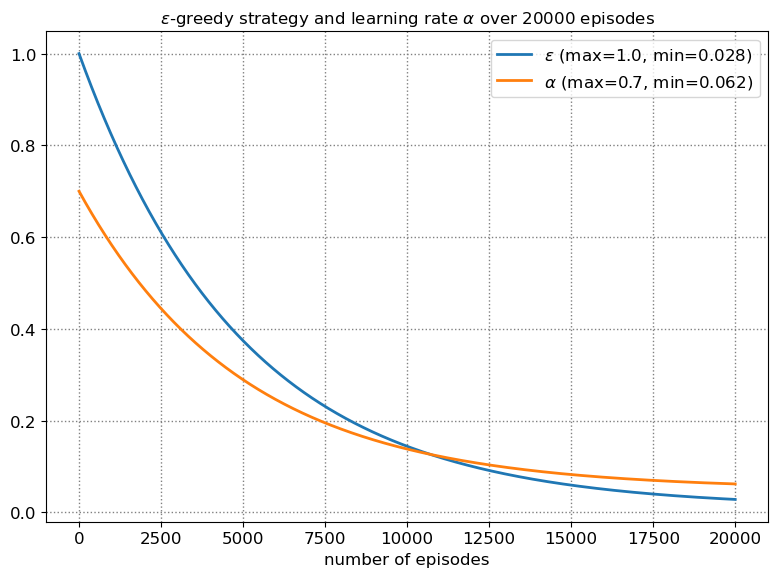

In [40]:
fp = os.path.join(fp_outputs,'IQL_run1')
if not os.path.exists(fp): os.makedirs(fp)

# training parameters
train_params = {
    'n_episodes': 20000,         # number of episodes for the search
    'max_epsilon': 1,         # max epsilon at the start of the search
    'min_epsilon': 0.01,        # minimum exploration rate
    'decay_epsilon': 0.0002,    # epsilon decay
    'max_alpha': 0.7,            # initial alpha value
    'min_alpha': 0.05,          # min alpha
    'decay_alpha': 0.0002,       # alpha decay
    'gamma': 0.9,               # discount factor
    'saving_step': 10,          # how often to save the model
    'n_decisions': 365,         # number of decisions per mini-episode,
    'repetitions': 10,
}

# plot epsilon and alpha decay curves
fig, epsilons, alphas = opfleet.plot_eps_alpha(train_params)
fig.savefig(os.path.join(fp,'epsilon_greedy_search.jpg'))

# store parameters in a text file for reference
with open(os.path.join(fp,'train_params.txt'),'w') as f:
    json.dump(train_params,f,indent=4)
    
# initialise environment
env = opfleet.Env(params,True)
plt.gcf().savefig(os.path.join(fp,'mission_profile.jpg'))
plt.close(plt.gcf())

# draw initial states for each episode from uniform distribution
nei = train_params['n_episodes']
crack_lengths = np.empty((nei,env.n_tail))
for k in range(env.n_tail):
    crack_lengths[:,k] = np.random.uniform(env.a0*1000,env.amax*1000,nei)
# uncomment for exponential distribution
# random_exp = stats.truncexpon(env.amax*1000,scale=10)
# for k in range(env.n_tail):
#     sampled_cracks = env.amax*1000-random_exp.rvs(nei)
#     sampled_cracks = sampled_cracks[sampled_cracks>=env.a0*1000]
#     crack_lengths[:,k] = np.random.choice(sampled_cracks,nei)
train_params['crack_lengths'] = crack_lengths

In [41]:
# randomly initialise q-table
n_agents = env.n_tail
q_tables = []
states = np.arange(1,10)
for i in range(n_agents):
    q_table = dict([])
    for s in states:     
                state = '%d'%(s)
                q_table[state] = np.random.uniform(-5,5,len(env.action_list))
    q_tables.append(q_table)

In [ ]:
q_tables = opfleet.train_IQL(env,q_tables,train_params,fp)

4050 - rew 4612 (best 4713) - eps 0.450 - alpha = 0.339

In [ ]:
N = 1000
for n_aircrafts in [6]:
    run_name = 'example_IQL_%dtails'%n_aircrafts
    # load env
    fp_outputs = os.path.join(os.getcwd(),run_name)
    with open(os.path.join(fp_outputs,'params.pkl'),'rb') as f:
        params = pickle.load(f) 
    env = opfleet.Env(params)
    # load qtable
    fp = os.path.join(fp_outputs,'IQL_run1')
    with open(os.path.join(fp,'qtable_best.pkl'),'rb') as f:
        q_tables = pickle.load(f)
    # find optimal maintenance threshold for each policy
    level_oncond, level_forcelife, level_equalstress, fig  = opfleet.optimise_baselines(env,repetitions=10)
    # run N episodes with each policy
    maint_levels = {'level_oncond':level_oncond,'level_forcelife':level_forcelife,'level_equalstress':level_equalstress}
    rewards_baselines = opfleet.run_episodes_baselines(env,maint_levels,N)
    # run N episodes with qtable
    rewards_qtable = opfleet.run_episodes_qtable_multiagent(env,q_tables,N)
    # store in files
    fp_baselines = os.path.join(fp_outputs,'reward_baselines.pkl')
    with open(fp_baselines,'wb') as f:
        pickle.dump(rewards_baselines,f)
    fp_RL = os.path.join(fp_outputs,'reward_RL_Qtable.pkl')
    with open(fp_RL,'wb') as f:
        pickle.dump(rewards_qtable,f)

In [ ]:
# plot comparisons
for n_aircrafts in [6]:
    run_name = 'example_IQL_%dtails'%n_aircrafts
    fp_outputs = os.path.join(os.getcwd(),run_name)
    fp_baselines = os.path.join(fp_outputs,'reward_baselines.pkl')
    with open(fp_baselines,'rb') as f:
        rewards_baselines = pickle.load(f)
    fp_RL = os.path.join(fp_outputs,'reward_RL_Qtable.pkl')
    with open(fp_RL,'rb') as f:
        rewards_qtable = pickle.load(f)
    rewards_baselines['RL_IQL'] = rewards_qtable
    # plot reward distributions
    fig = opfleet.plot_reward_distributions(rewards_baselines, binwidth=5)
    fig.suptitle('%d aircraft environment'%n_aircrafts)
    fig.savefig(os.path.join(fp_outputs,'policy_evaluation.jpg'))